In [1]:
import pandas as pd
import numpy as np
import os 
from datetime import datetime, timedelta
import yfinance as yf  # This gets us prices from Yahoo finance. See https://pypi.org/project/yfinance/
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf
if os.name=='nt':
    import xlwings as xw

---

### Fama French Three factor model ###

---


**Get data from Yahoo finance**

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

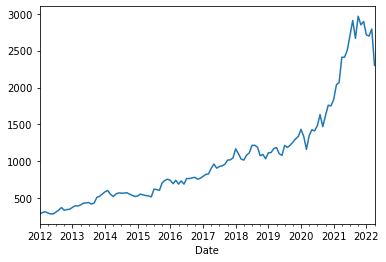

In [2]:
data = yf.download(tickers="GOOG", start='2012-01-01', end='2022-05-01', interval="1mo")['Adj Close'].dropna()
data.plot()

In [3]:
data.tail()

Date
2021-12-01    2893.590088
2022-01-01    2713.969971
2022-02-01    2697.820068
2022-03-01    2792.989990
2022-04-01    2299.330078
Name: Adj Close, dtype: float64

**Convert the closing data into returns**

<AxesSubplot:xlabel='Date'>

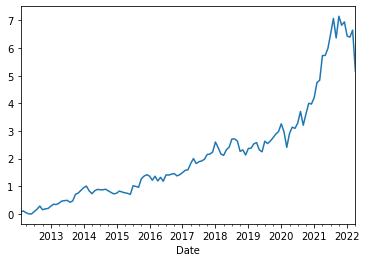

In [4]:
dfr = np.log(data).diff().dropna()
dfr.name="ret_i"
dfr.add(1).cumprod().sub(1).plot()


In [5]:
dfr.tail()

Date
2021-12-01    0.015516
2022-01-01   -0.064085
2022-02-01   -0.005968
2022-03-01    0.034669
2022-04-01   -0.194495
Name: ret_i, dtype: float64

---

**Get the factor data from the website of Ken French**

In [6]:
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
df = pd.read_csv(url, skiprows =[0,1,2], on_bad_lines ='skip', nrows=1150, compression='zip').rename(columns = {'Unnamed: 0':'date', 'Mkt-RF': 'mkt_rf' }).set_index("date")
df.index = pd.to_datetime(df.index, format ='%Y%m')
df.columns = df.columns.str.lower()
df.tail()

,mkt_rf,smb,hml,rf
date,,,,
2021-12-01,3.10,-1.60,3.22,0.01
2022-01-01,-6.25,-5.93,12.74,0.00
2022-02-01,-2.29,2.18,3.09,0.00
2022-03-01,3.06,-1.61,-1.82,0.00
2022-04-01,-9.44,-1.40,6.16,0.00


**Turn these numbers into decimals**

In [7]:
dff = df/100

In [8]:
dff.tail()

,mkt_rf,smb,hml,rf
date,,,,
2021-12-01,0.0310,-0.0160,0.0322,0.0001
2022-01-01,-0.0625,-0.0593,0.1274,0.0000
2022-02-01,-0.0229,0.0218,0.0309,0.0000
2022-03-01,0.0306,-0.0161,-0.0182,0.0000
2022-04-01,-0.0944,-0.0140,0.0616,0.0000


**Join returns with FF data**

In [9]:
dff = dff.join(dfr).dropna()

In [10]:
dff.tail()

,mkt_rf,smb,hml,rf,ret_i
date,,,,,
2021-12-01,0.0310,-0.0160,0.0322,0.0001,0.015516
2022-01-01,-0.0625,-0.0593,0.1274,0.0000,-0.064085
2022-02-01,-0.0229,0.0218,0.0309,0.0000,-0.005968
2022-03-01,0.0306,-0.0161,-0.0182,0.0000,0.034669
2022-04-01,-0.0944,-0.0140,0.0616,0.0000,-0.194495


**Determine excess returns**

In [11]:
dff['xs_ret'] = dff['ret_i'].sub(dff['rf'])
dff.tail()

,mkt_rf,smb,hml,rf,ret_i,xs_ret
date,,,,,,
2021-12-01,0.0310,-0.0160,0.0322,0.0001,0.015516,0.015416
2022-01-01,-0.0625,-0.0593,0.1274,0.0000,-0.064085,-0.064085
2022-02-01,-0.0229,0.0218,0.0309,0.0000,-0.005968,-0.005968
2022-03-01,0.0306,-0.0161,-0.0182,0.0000,0.034669,0.034669
2022-04-01,-0.0944,-0.0140,0.0616,0.0000,-0.194495,-0.194495


---

**Now we can run the regression using the factors**

In [12]:
results = smf.ols('xs_ret ~ 1 + mkt_rf + smb + hml', data=dff).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 xs_ret   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     35.91
Date:                Tue, 31 May 2022   Prob (F-statistic):           1.34e-16
Time:                        09:38:19   Log-Likelihood:                 205.31
No. Observations:                 123   AIC:                            -402.6
Df Residuals:                     119   BIC:                            -391.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0036      0.004      0.824      0.4

**The factor coefficients are:** 

In [13]:
factors = results.params.to_frame()
factors.columns=['coefficients']
factors

,coefficients
Intercept,0.003597
mkt_rf,1.107069
smb,-0.434809
hml,-0.204250


**Now apply this to the mean values of the firm**

In [14]:
means = dff.mean().to_frame()
means.columns=['mean']
means

,mean
mkt_rf,0.011226
smb,-0.000768
hml,-0.000298
rf,0.000442
ret_i,0.016862
xs_ret,0.016420


In [15]:
means = means.join(factors)
means

,mean,coefficients
mkt_rf,0.011226,1.107069
smb,-0.000768,-0.434809
hml,-0.000298,-0.204250
rf,0.000442,NaN
ret_i,0.016862,NaN
xs_ret,0.016420,NaN


**Note that the coefficient on $r_f$ should be one, and that we do not need the means of the last two rows:**

In [16]:
means.loc['rf']['coefficients'] = 1
means.dropna(inplace=True)
means

,mean,coefficients
mkt_rf,0.011226,1.107069
smb,-0.000768,-0.434809
hml,-0.000298,-0.204250
rf,0.000442,1.000000


**Now calculate the cost of capital: $r_i = r_f + \beta^{mkt-rf} + \beta^{size}\cdot SMB + \beta^{value} \cdot HML$.**

In [17]:
ri = means['mean'] @ means['coefficients']

**Annualised: $r_i = 100\cdot[(1+r_i)^{12}-1]$**

In [18]:
ri = (ri+1)**12-1
ri *= 100
print(f"Cost of capital {ri:4.2f} percent.")

Cost of capital 17.13 percent.


**Compare to CAPM**

In [19]:
capm = smf.ols('xs_ret ~ 1 + mkt_rf', data=dff).fit()
print(capm.summary())

                            OLS Regression Results                            
Dep. Variable:                 xs_ret   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     93.17
Date:                Tue, 31 May 2022   Prob (F-statistic):           1.08e-16
Time:                        09:38:19   Log-Likelihood:                 200.78
No. Observations:                 123   AIC:                            -397.6
Df Residuals:                     121   BIC:                            -391.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0049      0.004      1.104      0.2

In [20]:
#if os.name=='nt':
#    wb = xw.Book()  
#    sheet = wb.sheets['Sheet1']
#    sheet.range('A1').value = means

In [21]:
# All in one

def famafrench(ticker, start, end, skiprows, endrow, url):
    data = yf.download(tickers=ticker, start=start, end=end, interval="1mo")['Adj Close'].dropna()

    # Returns 
    dfr = np.log(data).diff()
    dfr.name="ret_i"
    dfr.add(1).cumprod().sub(1).plot()

    # FF data
    #url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
    df = pd.read_csv(url, skiprows = skiprows, on_bad_lines ='skip', nrows=endrow, compression='zip').rename(columns = {'Unnamed: 0':'date', 'Mkt-RF': 'mkt_rf' }).set_index("date")
    df.index = pd.to_datetime(df.index, format ='%Y%m')
    df.columns = df.columns.str.lower()

    # Mungeing data
    dff = df/100
    dff = dff.join(dfr).dropna()
    dff['xs_ret'] = dff['ret_i'].sub(dff['rf'])

    # Run the regression
    results = smf.ols('xs_ret ~ 1 + mkt_rf + smb + hml', data=dff).fit()
    print(results.summary())
    
    capm = smf.ols('xs_ret ~ 1 + mkt_rf', data=dff).fit()
    print(capm.summary())

    # Calculate the cost of capital
    factors = results.params.to_frame()
    factors.columns=['coefficients']

    means = dff.mean().to_frame()
    means.columns=['mean']

    means = means.join(factors)

    means.loc['rf']['coefficients'] = 1
    means.dropna(inplace=True)
    
    ri = 100*((means['mean'] @ means['coefficients']+1)**12-1)
    #ri = (ri+1)**12-1
    #ri *= 100
    print(f"\nCost of capital {ri:4.2f} percent.")
    return means

[*********************100%***********************]  1 of 1 completed
                            OLS Regression Results                            
Dep. Variable:                 xs_ret   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     35.91
Date:                Tue, 31 May 2022   Prob (F-statistic):           1.34e-16
Time:                        09:38:20   Log-Likelihood:                 205.31
No. Observations:                 123   AIC:                            -402.6
Df Residuals:                     119   BIC:                            -391.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

,mean,coefficients
mkt_rf,0.011226,1.107069
smb,-0.000768,-0.434809
hml,-0.000298,-0.204250
rf,0.000442,1.000000


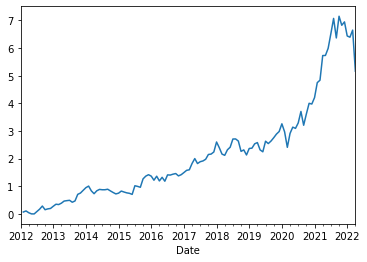

In [22]:
famafrench("GOOG", '2012-01-01', '2022-05-01', [0,1,2], 1150, "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip")


[*********************100%***********************]  1 of 1 completed
                            OLS Regression Results                            
Dep. Variable:                 xs_ret   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     4.430
Date:                Tue, 31 May 2022   Prob (F-statistic):            0.00710
Time:                        09:38:21   Log-Likelihood:                 84.131
No. Observations:                  63   AIC:                            -160.3
Df Residuals:                      59   BIC:                            -151.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

,mean,coefficients
mkt_rf,0.004683,0.442478
smb,-0.003383,0.974856
hml,0.000383,-0.105155
rf,0.000813,1.000000


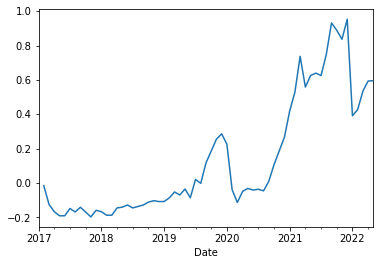

In [23]:
url = "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Asia_Pacific_ex_Japan_3_Factors_CSV.zip"
df = famafrench("WHS.NZ", '2017-01-01', '2022-05-01', [0,1,2,3,4,5], 382, url)
df